 ## Download from google drive & create json file



In [1]:
# !gdown 1VFZDI21HXbVQRJOawGxAiQZxFERysLC4 -O datasets.zip

# !unzip ./datasets.zip

In [2]:
# import os
# import json

# # Set the path to data directory
# data_dir = "./BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

# base_dir = "MICCAI_BraTS2020_TrainingData/"
# # Get a list of all directories in the data directory
# all_dirs = os.listdir(data_dir)

# # Create a list of all file paths by joining data directory and directory names
# all_paths = [os.path.join(data_dir, d) for d in all_dirs]

# # Calculate sizes for training, validation, and test sets
# size = len(all_paths)
# train_size = int(0.7 * size)
# val_size = int(0.1 * size)

# # Split the file paths into training, validation, and test sets
# train_files = all_paths[:train_size]
# val_files = all_paths[train_size:train_size + val_size]
# test_files = all_paths[train_size + val_size:]

# # Function to extract ID from file path
# def extract_id_from_path(file_path):
#     return file_path.split("/")[-1]

# # Create a list for training samples
# training_samples = []
# for file_path in train_files:
#     id = extract_id_from_path(file_path)
#     if "csv" in id:
#       continue
#     sample = {
#         "fold": 0,  # Set fold to 0 to indicate it's in the training set
#         "image": [
#             os.path.join(base_dir, f"{id}/{id}_flair.nii"),
#             os.path.join(base_dir, f"{id}/{id}_t1ce.nii"),
#             os.path.join(base_dir, f"{id}/{id}_t1.nii"),
#             os.path.join(base_dir, f"{id}/{id}_t2.nii")
#         ],
#         "label": os.path.join(base_dir, f"{id}/{id}_seg.nii")
#     }
#     training_samples.append(sample)

# # Create a list for validation samples
# validation_samples = []
# for file_path in val_files:
#     id = extract_id_from_path(file_path)
#     if "csv" in id:
#       continue
#     sample = {
#         "fold": 1,  # Set fold to 1 to indicate it's in the validation set
#         "image": [
#             os.path.join(base_dir, f"{id}/{id}_flair.nii"),
#             os.path.join(base_dir, f"{id}/{id}_t1ce.nii"),
#             os.path.join(base_dir, f"{id}/{id}_t1.nii"),
#             os.path.join(base_dir, f"{id}/{id}_t2.nii")
#         ],
#         "label": os.path.join(base_dir, f"{id}/{id}_seg.nii")
#     }
#     validation_samples.append(sample)

# # Create a list for test samples
# test_samples = []
# for file_path in test_files:
#     id = extract_id_from_path(file_path)
#     if "csv" in id:
#       continue
#     sample = {
#         "fold": 2,  # Set fold to 2 to indicate it's in the test set
#         "image": [
#             os.path.join(base_dir, f"{id}/{id}_flair.nii"),
#             os.path.join(base_dir, f"{id}/{id}_t1ce.nii"),
#             os.path.join(base_dir, f"{id}/{id}_t1.nii"),
#             os.path.join(base_dir, f"{id}/{id}_t2.nii")
#         ],
#         "label": os.path.join(base_dir, f"{id}/{id}_seg.nii")
#     }
#     test_samples.append(sample)

# # Combine all samples into one list
# all_samples = training_samples + validation_samples + test_samples

# # Create JSON data structure
# all_data = {"training": all_samples}

# # Convert the dictionary to a JSON string
# json_data = json.dumps(all_data, indent=4)

# # Write the JSON string to a file
# with open('brats20_folds.json', 'w') as json_file:
#     json_file.write(json_data)


## Setup environment

In [3]:
# !pip install -r requirements.txt

In [4]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [5]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SegResNet
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch
from tqdm import tqdm


print_config()

MONAI version: 0.8.1+271.g07de215c
Numpy version: 1.23.5
Pytorch version: 1.12.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 07de215caf79dabec20ac53fb38d9f2df36f182a
MONAI __file__: /home/pippi/anaconda3/envs/DLCV/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.1.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.4.0
Tensorboard version: 2.14.0
gdown version: 4.7.1
TorchVision version: 0.13.1
tqdm version: 4.59.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [6]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp8_tlrvs9


## Setup average meter, fold reader, checkpoint saver

In [7]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)

# Add test data
def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
                #print([os.path.join(basedir, iv) for iv in d[k]])
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    test = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        elif "fold" in d and d["fold"] == 2:
            test.append(d)
        else:
            tr.append(d)

    return tr, val, test


def save_checkpoint(model, epoch, filename="model.pt", best_acc=0, dir_add=root_dir):
    state_dict = model.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
    filename = os.path.join(dir_add, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

## Setup dataloader

In [8]:
# Add test dataloader
def get_loader(batch_size, data_dir, json_list, fold, roi):
    data_dir = data_dir
    datalist_json = json_list
    train_files, validation_files, test_files = datafold_read(datalist=datalist_json, basedir=data_dir, fold=fold)
    print(len(train_files), len(validation_files), len(test_files))
    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.CropForegroundd(
                keys=["image", "label"],
                source_key="image",
                k_divisible=[roi[0], roi[1], roi[2]],
            ),
            transforms.RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[roi[0], roi[1], roi[2]],
                random_size=False,
            ),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ]
    )
    val_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ]
    )

    train_ds = data.Dataset(data=train_files, transform=train_transform)

    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
    )
    val_ds = data.Dataset(data=validation_files, transform=val_transform)
    val_loader = data.DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=8,
        pin_memory=True,
    )

    test_ds = data.Dataset(data=test_files, transform=val_transform)
    test_loader = data.DataLoader(
        test_ds,
        batch_size=1,
        shuffle=False,
        num_workers=8,
        pin_memory=True,
    )
    print(len(train_loader), len(val_loader), len(test_loader))
    return train_loader, val_loader, test_loader

## Set dataset root directory and hyper-parameters

The following hyper-parameters are set for the purpose of this tutorial. However, additional changes, as described below, maybe beneficial.

If GPU memory is not sufficient, reduce sw_batch_size to 2 or batch_size to 1.

Decrease val_every (validation frequency) to 1 for obtaining more accurate checkpoints.

In [9]:
data_dir = "./BraTS2020_TrainingData"
json_list = "./brats20_folds.json"
roi = (240, 240, 160)
batch_size = 1
sw_batch_size = 1
fold = 1
infer_overlap = 0.5
max_epochs = 300
val_every = 10
train_loader, val_loader, test_loader = get_loader(batch_size, data_dir, json_list, fold, roi)

257 37 75
257 37 75


## Check data shape and visualize

image shape: (240, 240, 155), label shape: (240, 240, 155)


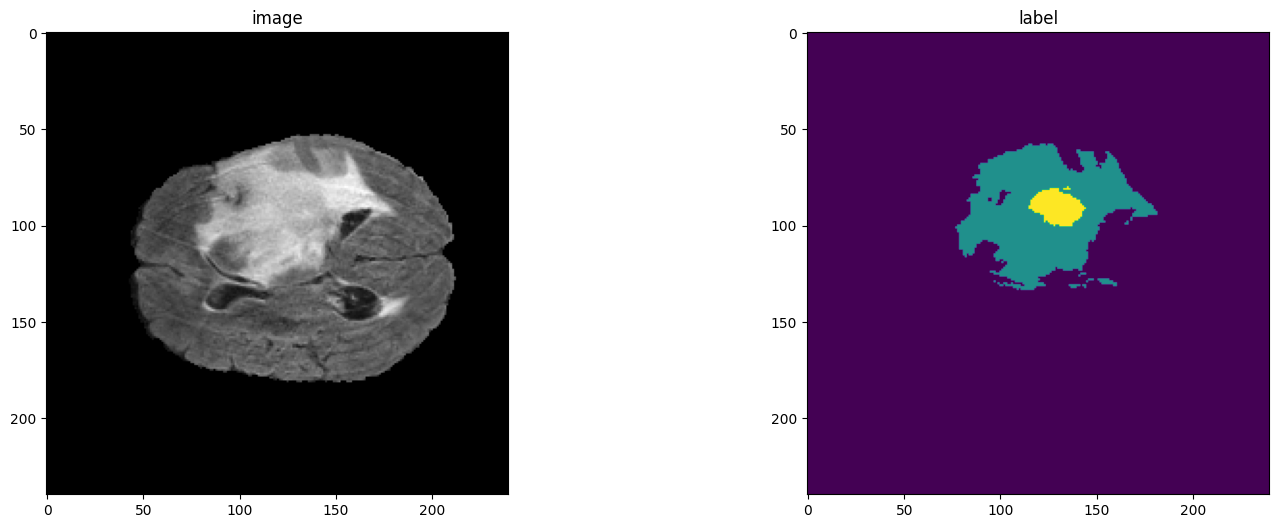

In [10]:
img_add = os.path.join(data_dir, "MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii")
label_add = os.path.join(data_dir, "MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii")
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
print(f"image shape: {img.shape}, label shape: {label.shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[:, :, 78], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 78])
plt.show()

## Create SegResNet model

In [11]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)

## Optimizer and loss function

In [12]:
torch.backends.cudnn.benchmark = True
dice_loss = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)
dice_acc = DiceMetric(include_background=True, reduction=MetricReduction.MEAN_BATCH, get_not_nans=True)
model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

## Define Train and Validation Epoch

In [13]:
def train_epoch(model, loader, optimizer, epoch, loss_func):
    model.train()
    # start_time = time.time()
    run_loss = AverageMeter()
    for batch_data in tqdm(loader):
        data, target = batch_data["image"].to(device), batch_data["label"].to(device)
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()
        run_loss.update(loss.item(), n=batch_size)
        # print(
        #     "Epoch {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
        #     "loss: {:.4f}".format(run_loss.avg),
        #     "time {:.2f}s".format(time.time() - start_time),
        # )
        # start_time = time.time()
    return run_loss.avg


def val_epoch(
    model,
    loader,
    epoch,
    acc_func,
    model_inferer=None,
    post_sigmoid=None,
    post_pred=None,
):
    model.eval()
    # start_time = time.time()
    run_acc = AverageMeter()

    with torch.no_grad():
        for batch_data in tqdm(loader):
            data, target = batch_data["image"].to(device), batch_data["label"].to(device)
            logits = model_inferer(data)
            val_labels_list = decollate_batch(target)
            val_outputs_list = decollate_batch(logits)
            val_output_convert = [post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in val_outputs_list]
            acc_func.reset()
            acc_func(y_pred=val_output_convert, y=val_labels_list)
            acc, not_nans = acc_func.aggregate()
            run_acc.update(acc.cpu().numpy(), n=not_nans.cpu().numpy())
            dice_tc = run_acc.avg[0]
            dice_wt = run_acc.avg[1]
            dice_et = run_acc.avg[2]
            # print(
            #     "Val {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
            #     ", dice_tc:",
            #     dice_tc,
            #     ", dice_wt:",
            #     dice_wt,
            #     ", dice_et:",
            #     dice_et,
            #     ", time {:.2f}s".format(time.time() - start_time),
            # )
            # start_time = time.time()

    return run_acc.avg

## Define Trainer

In [14]:
def trainer(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_func,
    acc_func,
    scheduler,
    model_inferer=None,
    start_epoch=0,
    post_sigmoid=None,
    post_pred=None,
):
    val_acc_max = 0.0
    dices_tc = []
    dices_wt = []
    dices_et = []
    dices_avg = []
    loss_epochs = []
    trains_epoch = []
    for epoch in range(start_epoch, max_epochs):
        print(time.ctime(), "Epoch:", epoch)
        epoch_time = time.time()
        train_loss = train_epoch(
            model,
            train_loader,
            optimizer,
            epoch=epoch,
            loss_func=loss_func,
        )
        print(
            "Final training  {}/{}".format(epoch, max_epochs - 1),
            "loss: {:.4f}".format(train_loss),
            "time {:.2f}s".format(time.time() - epoch_time),
        )

        if (epoch + 1) % val_every == 0 or epoch == 0:
            loss_epochs.append(train_loss)
            trains_epoch.append(int(epoch))
            epoch_time = time.time()
            val_acc = val_epoch(
                model,
                val_loader,
                epoch=epoch,
                acc_func=acc_func,
                model_inferer=model_inferer,
                post_sigmoid=post_sigmoid,
                post_pred=post_pred,
            )
            dice_tc = val_acc[0]
            dice_wt = val_acc[1]
            dice_et = val_acc[2]
            val_avg_acc = np.mean(val_acc)
            print(
                "Final validation stats {}/{}".format(epoch, max_epochs - 1),
                ", dice_tc:",
                dice_tc,
                ", dice_wt:",
                dice_wt,
                ", dice_et:",
                dice_et,
                ", Dice_Avg:",
                val_avg_acc,
                ", time {:.2f}s".format(time.time() - epoch_time),
            )
            dices_tc.append(dice_tc)
            dices_wt.append(dice_wt)
            dices_et.append(dice_et)
            dices_avg.append(val_avg_acc)
            if val_avg_acc > val_acc_max:
                print("new best ({:.6f} --> {:.6f}). ".format(val_acc_max, val_avg_acc))
                val_acc_max = val_avg_acc
                save_checkpoint(
                    model,
                    epoch,
                    best_acc=val_acc_max,
                    dir_add = './'
                )
            scheduler.step()
    print("Training Finished !, Best Accuracy: ", val_acc_max)
    return (
        val_acc_max,
        dices_tc,
        dices_wt,
        dices_et,
        dices_avg,
        loss_epochs,
        trains_epoch,
    )

## Execute training

In [15]:
# start_epoch = 0

# (
#     val_acc_max,
#     dices_tc,
#     dices_wt,
#     dices_et,
#     dices_avg,
#     loss_epochs,
#     trains_epoch,
# ) = trainer(
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     optimizer=optimizer,
#     loss_func=dice_loss,
#     acc_func=dice_acc,
#     scheduler=scheduler,
#     model_inferer=model_inferer,
#     start_epoch=start_epoch,
#     post_sigmoid=post_sigmoid,
#     post_pred=post_pred,
# )

In [16]:
# print(f"train completed, best average dice: {val_acc_max:.4f} ")
# Final validation stats 59/299 , dice_tc: 0.68023705 , dice_wt: 0.78890765 , dice_et: 0.56848985 , Dice_Avg: 0.67921156 , time 12.75s

### Plot the loss and Dice metric

In [17]:
# plt.figure("train", (12, 6))
# plt.subplot(1, 2, 1)
# plt.title("Epoch Average Loss")
# plt.xlabel("epoch")
# plt.plot(trains_epoch, loss_epochs, color="red")
# plt.subplot(1, 2, 2)
# plt.title("Val Mean Dice")
# plt.xlabel("epoch")
# plt.plot(trains_epoch, dices_avg, color="green")
# plt.show()
# plt.figure("train", (18, 6))
# plt.subplot(1, 3, 1)
# plt.title("Val Mean Dice TC")
# plt.xlabel("epoch")
# plt.plot(trains_epoch, dices_tc, color="blue")
# plt.subplot(1, 3, 2)
# plt.title("Val Mean Dice WT")
# plt.xlabel("epoch")
# plt.plot(trains_epoch, dices_wt, color="brown")
# plt.subplot(1, 3, 3)
# plt.title("Val Mean Dice ET")
# plt.xlabel("epoch")
# plt.plot(trains_epoch, dices_et, color="purple")
# plt.show()

## Create test set dataloader

In [18]:
case_num = "001"

test_files = [
    {
        "image": [
            os.path.join(
                data_dir,
                "MICCAI_BraTS2020_TrainingData/BraTS20_Training_" + case_num + "/BraTS20_Training_" + case_num + "_flair.nii",
            ),
            os.path.join(
                data_dir,
                "MICCAI_BraTS2020_TrainingData/BraTS20_Training_" + case_num + "/BraTS20_Training_" + case_num + "_t1ce.nii",
            ),
            os.path.join(
                data_dir,
                "MICCAI_BraTS2020_TrainingData/BraTS20_Training_" + case_num + "/BraTS20_Training_" + case_num + "_t1.nii",
            ),
            os.path.join(
                data_dir,
                "MICCAI_BraTS2020_TrainingData/BraTS20_Training_" + case_num + "/BraTS20_Training_" + case_num + "_t2.nii",
            ),
        ],
        "label": os.path.join(
            data_dir,
            "MICCAI_BraTS2020_TrainingData/BraTS20_Training_" + case_num + "/BraTS20_Training_" + case_num + "_seg.nii",
        ),
    }
]

test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

test_ds = data.Dataset(data=test_files, transform=test_transform)

test_loader = data.DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

## Load the best saved checkpoint and perform inference

We select a single case from the validation set and perform inference to compare the model segmentation output with the corresponding label.

In [19]:
model.load_state_dict(torch.load(os.path.join('./', "model.pt"))["state_dict"])
model.to(device)
model.eval()

model_inferer_test = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
)


with torch.no_grad():
    for batch_data in test_loader:
        image = batch_data["image"].cuda()
        prob = torch.sigmoid(model_inferer_test(image))
        seg = prob[0].detach().cpu().numpy()
        seg = (seg > 0.5).astype(np.int8)
        seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
        seg_out[seg[1] == 1] = 2
        seg_out[seg[0] == 1] = 1
        seg_out[seg[2] == 1] = 4

## Visualize segmentation output and compare with label

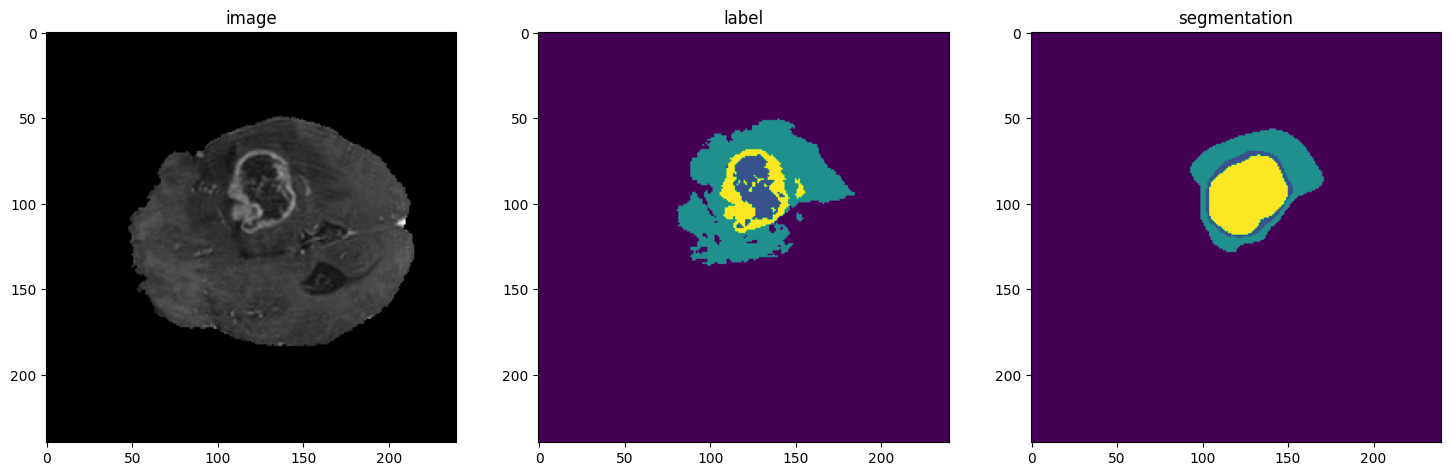

In [20]:
slice_num = 67
img_add = os.path.join(
    data_dir,
    "MICCAI_BraTS2020_TrainingData/BraTS20_Training_" + case_num + "/BraTS20_Training_" + case_num + "_t1ce.nii",
)
label_add = os.path.join(
    data_dir,
    "MICCAI_BraTS2020_TrainingData/BraTS20_Training_" + case_num + "/BraTS20_Training_" + case_num + "_seg.nii",
)
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(img[:, :, slice_num], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
plt.imshow(label[:, :, slice_num])
plt.subplot(1, 3, 3)
plt.title("segmentation")
plt.imshow(seg_out[:, :, slice_num])
plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [21]:
if directory is None:
    shutil.rmtree(root_dir)